# **Wine Quality Classification**

The data was downloaded from UCI Machine Learning Repository: https://archive.ics.uci.edu/dataset/186/wine+quality

The two datasets are related to red and white variants of the Portuguese “Vinho Verde” wine. For more details, consult: [Web Link](http://www.vinhoverde.pt/en/) or the reference [Cortez et al., 2009].

These datasets were compiled using samples of red and white wines. The data includes objective measurements like pH values and the outcome is based on sensory evaluations, with the wine quality rated on a scale from 0 (very bad) to 10 (excellent) by wine experts. Each rating represents the median of at least three assessments by these experts. Due to privacy and logistical reasons, only the physicochemical properties (inputs) and the sensory ratings (outputs) are available, with no information on grape varieties, brand names, or prices.  Also, the creators are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

The data can be approached as either a classification or regression problem. The goal is to classify the dataset into different quality categories. To achieve this, distinct machine learning models will be developed and evaluated to identify the most effective one.

# 1. Initial Setup


## 1.1 Installations




### Package Descriptions


*   **ucimlrepo**: This package facilitates the direct fetching of datasets from the UCI Machine Learning Repository, allowing for easy integration into data processing pipelines.
*   **Boruta**: Boruta is a feature selection algorithm. It works by iteratively removing features that are proven by a statistical test to be less relevant for predicting the target variable.
*   **imbalanced-learn**: This library provides tools for dealing with imbalanced datasets, which is crucial for our project since the wine quality dataset has more normal wines than excellent or poor ones. It offers various resampling techniques to adjust the class distribution.









In [1]:
!pip install ucimlrepo
!pip install boruta
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.4 MB/s eta 0:00:00


## 1.2 Import of required libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
import joblib
from ucimlrepo import fetch_ucirepo

## 1.3 Load data from UCI repo

To work with the wine quality dataset for our classification task, we will first fetch the dataset using the ucimlrepo Python package.

In [17]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'title': 'Modeling wine preferences by data mining from physicoc

# 2. Exploratory Data Analysis (EDA)

### 2.1 Display the first few rows of the dataset

In [4]:
print(X.head())




   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4  


### 2.2 Statistical description of the features

In [5]:
print(X.describe())


       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

### 2.3 Check for missing values

The analysis confirms that there are no missing values in the dataset across all variables. This indicates excellent data completeness

In [6]:
print(X.isnull().sum())

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64


### 2.4 Visualizing the Distribution of Wine Quality

This bar chart shows the distribution of wine quality ratings in the dataset. The majority of wines are rated either 5 or 6, indicating that most fall into the average quality range. There are fewer wines rated 3, 4, 7, and 8, with very few reaching a quality rating of 9. This distribution suggests that extremely high or low quality wines are rare, with most wines clustering around the middle quality ratings. This unbalanced distribution can impact the performance of machine learning models, potentially leading to biases towards predicting more common classes. It's important to consider methods such as resampling or using different performance metrics that can handle class imbalance effectively during model training.

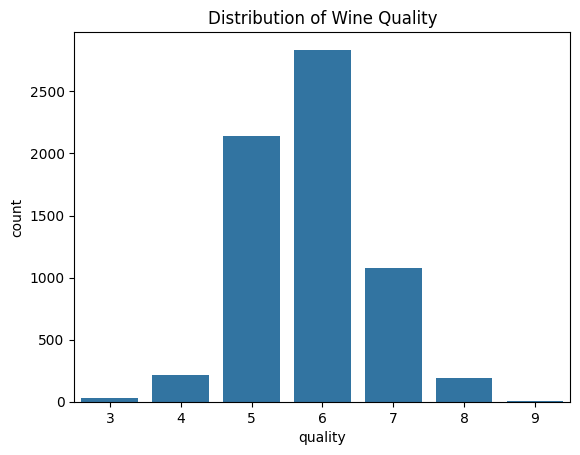

In [7]:
# Convert the target variable to a DataFrame if it's a Series
if isinstance(y, pd.Series):
    y = y.to_frame()

# Distribution of the target variable
sns.countplot(x=y.columns[0], data=y)  # Assuming y is now a DataFrame
plt.title("Distribution of Wine Quality")
plt.show()


### 2.5 Analyzing Feature Correlations


This correlation matrix  visualizes the relationships between different physicochemical properties of wines. Key observations include:

**High Correlation Pairs**: There are notably strong correlations between certain variables:

*   free_sulfur_dioxide and total_sulfur_dioxide show a very high positive
correlation (0.72), indicating that these two features might represent related or overlapping information.
*   density and alcohol exhibit a strong negative correlation (-0.69), suggesting that wines with higher alcohol content tend to have lower density.

**Moderate Correlations:**

*   citric_acid has a moderate positive correlation with fixed_acidity (0.32) and density (0.36), which might be indicative of how these chemical properties interact in wine composition.
*   volatile_acidity shows moderate negative correlations with citric_acid (-0.38) and alcohol (-0.04), suggesting how these elements affect the wine’s volatility and overall profile.
Low or Insignificant Correlations:

Many pairs of variables exhibit low or negligible correlations, indicating that they contribute independently to the wine's characteristics, such as pH and sulphates (0.19), or residual_sugar and chlorides (0.04).

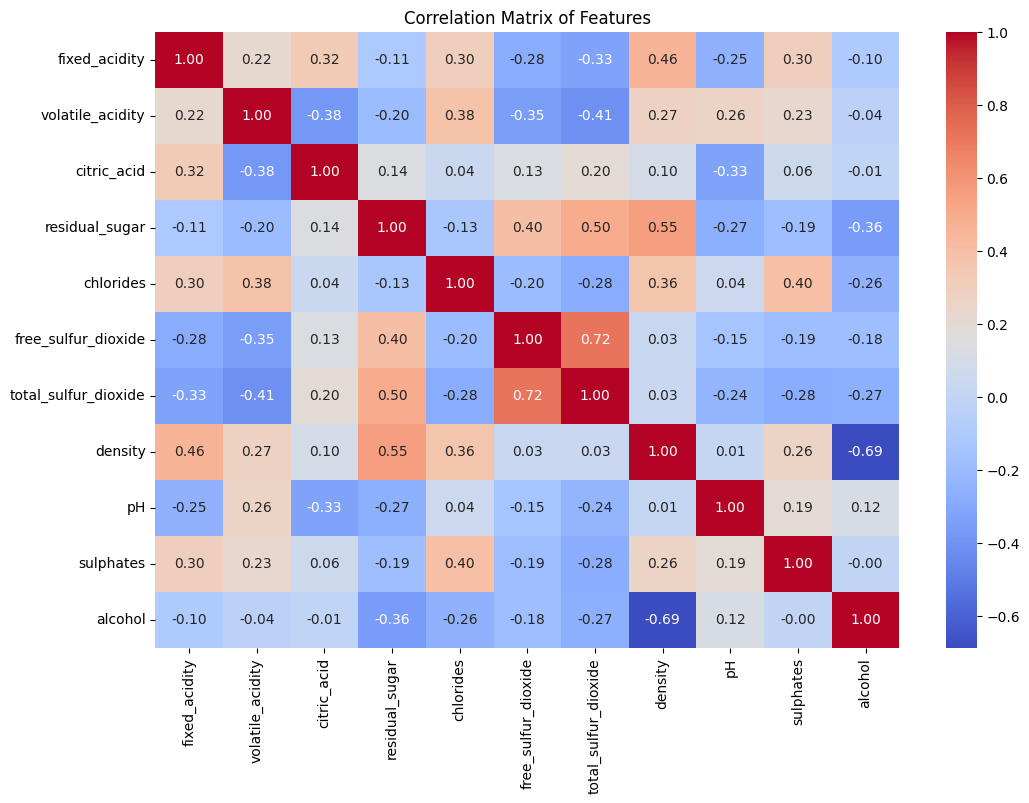

In [8]:
# Correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Features")
plt.show()

### 2.6 Outlier Detection

The boxplot visualization displays the distribution of various physicochemical features of wines. Observations from the boxplots include:

*   **Outliers**: Several features like residual sugar, chlorides, and free sulfur dioxide show a significant number of outliers above the upper quartile, suggesting that some wines have unusually high levels of these chemicals.

*   **Spread and Variability**: The total sulfur dioxide feature shows a wide interquartile range, indicating substantial variability among wines in this chemical property. This could affect the taste and preservation qualities of the wine.

*   **Central Tendency**: Most features have their medians near the lower quartile, except for density and pH, which appear more centrally located within their boxes. This suggests a skewed distribution for most features, where the majority of values are clustered towards the lower end of the scale.

*   **Scale of Features**: The scales of the features vary widely; for example, total sulfur dioxide values stretch far beyond the range of most other chemical properties. This might necessitate normalization or scaling during data preprocessing to ensure that all features contribute equally to analytical models.

These insights can guide further preprocessing steps such as feature scaling, which are crucial for building robust predictive models.

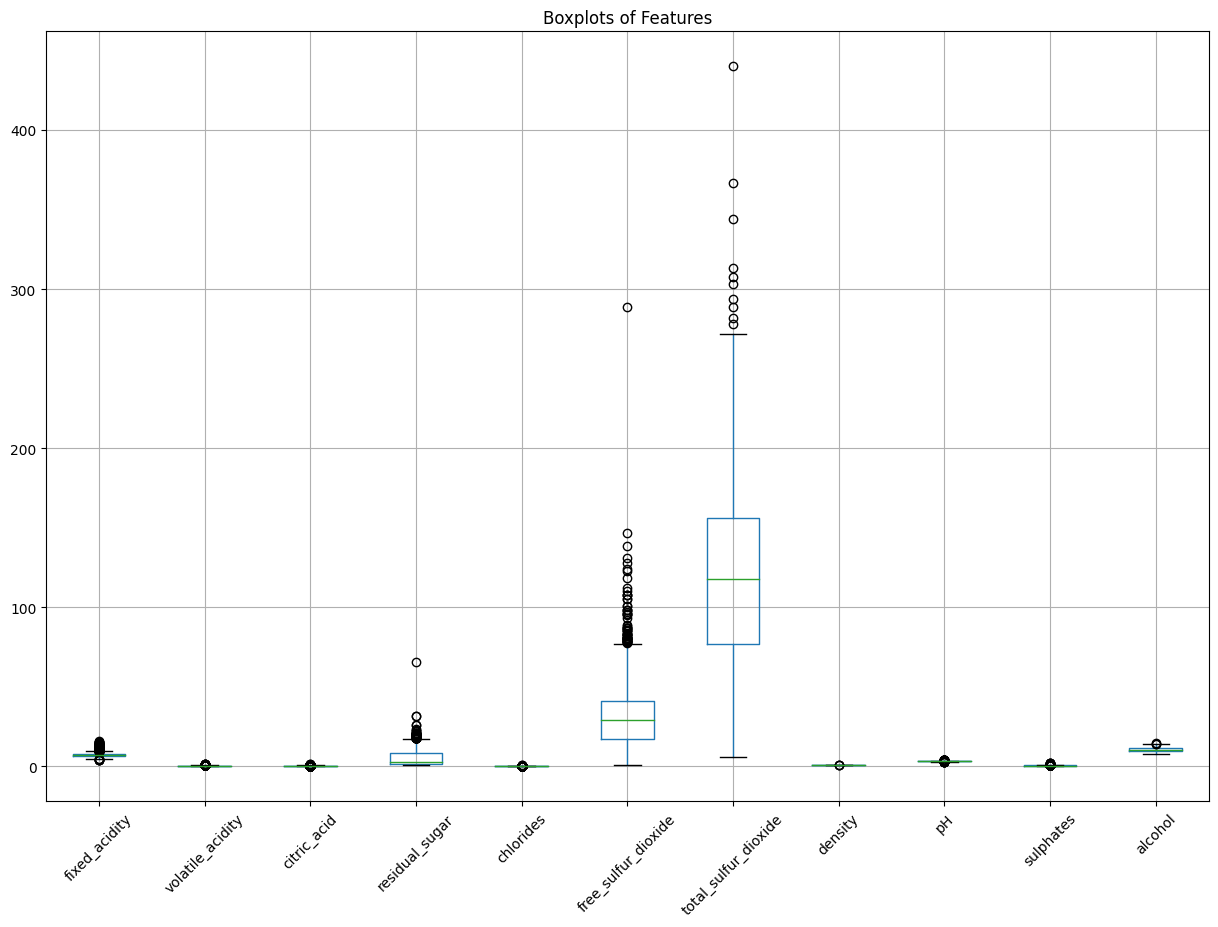

In [9]:
# Boxplots of each feature
plt.figure(figsize=(15, 10))
X.boxplot()
plt.title("Boxplots of Features")
plt.xticks(rotation=45)
plt.show()

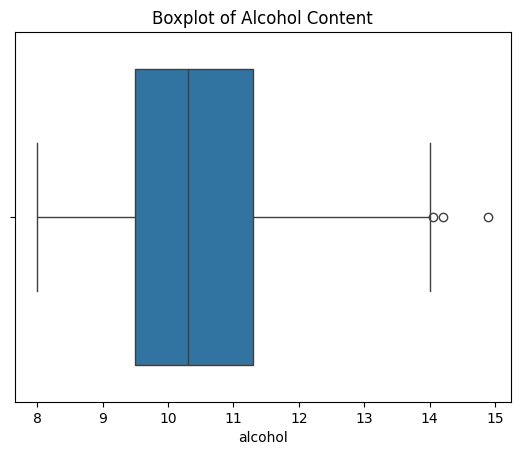

In [10]:
# Boxplot for 'alcohol'
sns.boxplot(x=X['alcohol'])
plt.title("Boxplot of Alcohol Content")
plt.show()

### 2.7 Histograms of each feature

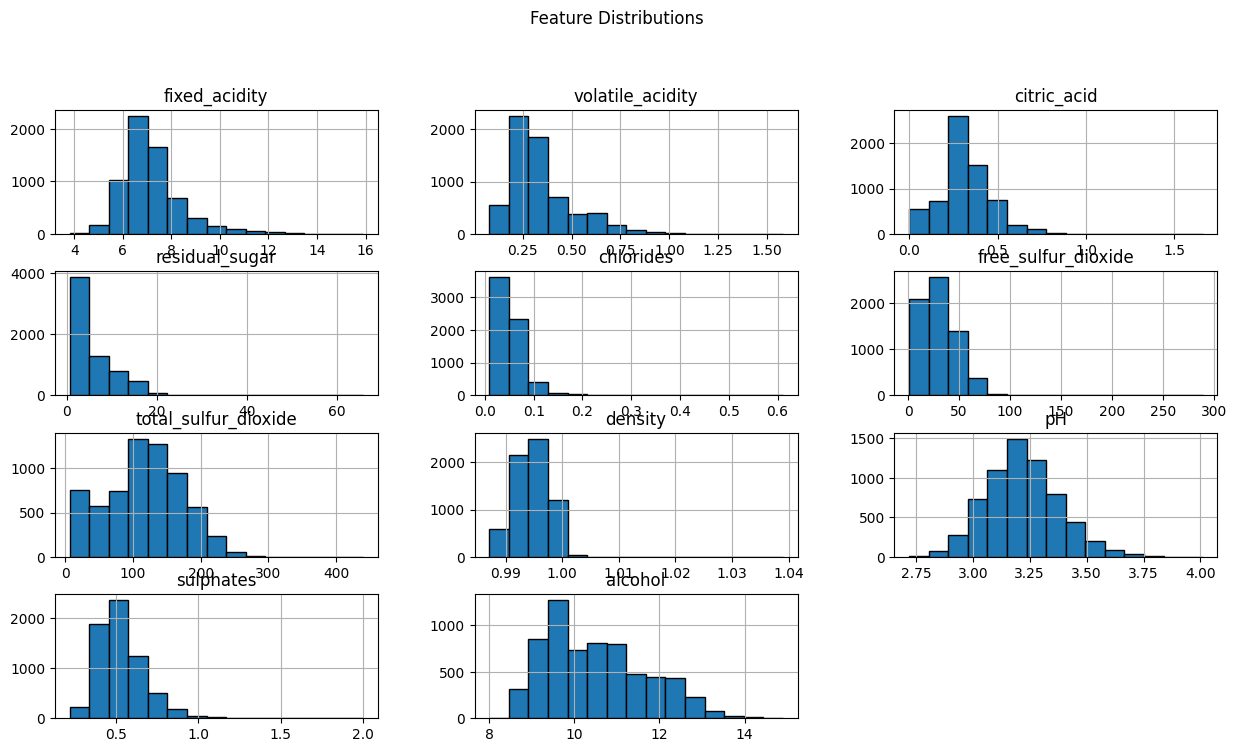

In [11]:
X.hist(bins=15, figsize=(15, 10), layout=(5, 3), edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

# 3. Data Preprocessing

## 3.1 Split and scaling

To ensure our models trains effectively and generalizes well to new data, we need to split our dataset into training and testing sets. Additionally, we'll apply feature scaling to standardize the range of our feature values.

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## 3.2 Feature Selection with Boruta

In our pursuit to enhance the predictive performance of our model on the wine quality dataset, we employ the Boruta algorithm, which significantly aids in selecting the most relevant features. Boruta works by comparing the importance of original features with the importance of shadow features (random permutations of real features) using a Random Forest classifier. This method ensures that only the features which have a genuine impact on the output variable are retained, thus improving model reliability and computational efficiency.

**Implementation Steps:**
*   Initialize the Random Forest Classifier: Set up with class balancing to account for any uneven distribution of classes and limited depth to prevent overfitting.
*   Configure and Execute Boruta: Specify the number of estimators as 'auto' for Boruta to decide based on the data, and set a high percentile to ensure robust feature selection.
*   Extract and Utilize Selected Features: Identify which features are deemed important and reduce the dataset accordingly for both training and testing phases.


Selected features by Boruta:

['fixed_acidity', 'volatile_acidity', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'alcohol']

*   Confirmed: 	7
*   Rejected: 	4

In [82]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest classifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Initialize Boruta
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42, perc = 80)

# Run Boruta
boruta_selector.fit(X_train, y_train.values)

# Check selected features
selected_features = X.columns[boruta_selector.support_].tolist()
print("Selected features by Boruta:")
print(selected_features)

# Reduce the dataset to the selected features
X_boruta = X_train[:, boruta_selector.support_]
X_test_boruta = X_test[:, boruta_selector.support_]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	3
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	17 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	18 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	19 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	20 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	21 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	22 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	23 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	24 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	25 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	26 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	27 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	28 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	29 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	30 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	31 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	32 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	33 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	34 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	35 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	36 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	37 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	38 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	39 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	40 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	41 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	42 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	43 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	44 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	45 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	46 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	47 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	48 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	49 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	50 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	51 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	52 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	53 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	54 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	55 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	56 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	57 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	58 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	59 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	60 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	61 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	62 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	63 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	64 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	65 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	66 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	67 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	68 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	69 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	70 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	71 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	72 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	73 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	74 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	75 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	76 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	77 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	78 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	79 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	80 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	81 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	82 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	83 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	84 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	85 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	86 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	87 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	88 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	89 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	90 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	91 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	92 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	93 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	94 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	95 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	96 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	97 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	98 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Iteration: 	99 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	3


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	4
Selected features by Boruta:
['fixed_acidity', 'volatile_acidity', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'alcohol']


## 3.3 Oversampling to Balance Classes

To tackle the class imbalance problem inherent in our wine quality dataset, we utilize the Synthetic Minority Over-sampling Technique (SMOTE). This technique generates synthetic samples from the minority class to ensure that our model is not biased towards the majority class, improving its ability to generalize across all quality levels.

SMOTE is configured with a lower number of neighbors to adapt to the size of the smallest minority class in our dataset. This is crucial for creating a balanced class distribution effectively.

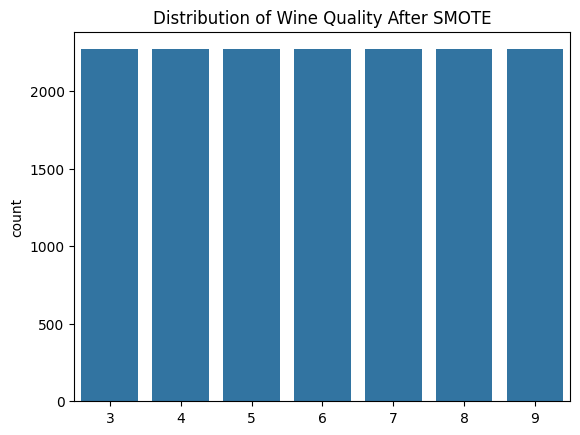

In [83]:
# Initialize SMOTE with a lower number of neighbors
smote = SMOTE(random_state=42, k_neighbors=2) # Set k_neighbors to a value less than or equal to the smallest minority class size

# Apply SMOTE to the reduced feature set
X_resampled, y_resampled = smote.fit_resample(X_boruta, y_train)

# Extract the values from the DataFrame into a 1D array
y_resampled_array = y_resampled.values.ravel()

# Check the distribution of the classes after resampling
sns.countplot(x=y_resampled_array) # Pass the 1D array to countplot
plt.title("Distribution of Wine Quality After SMOTE")
plt.show()

# 4. Model Training

## 4.1 Model Optimization with Hyperparameter Tuning


To optimize our predictive models for classifying wine quality, we employ a comprehensive approach using hyperparameter tuning via RandomizedSearchCV. This method allows us to explore a wide range of parameter settings for multiple algorithms, ensuring that we identify the most effective configurations for our models.

Configuration and Execution of Hyperparameter Search
We configure and execute a randomized search for several popular machine learning models, each with a specific set of parameters to explore:

*  **Random Forest**: A versatile ensemble method that is effective for both classification and regression tasks.
*   **Support Vector Machine (SVM)**: Known for its effectiveness in high-dimensional spaces and its ability to model non-linear decision boundaries.
*   **K-Nearest Neighbors (KNN)**: A simple yet powerful non-parametric classifier that makes predictions based on the proximity to other data points.
*   **Multilayer Perceptron (MLP)**: A type of neural network that is particularly good at capturing complex relationships in data.
*   **Decision Tree**: Provides a foundation for important ensemble methods and is easy to interpret.
*   **Gradient Boosting**: An advanced ensemble technique that combines multiple weak learning models to create a strong predictive model.

In [84]:
# Define models with pipelines and hyperparameter searches

# Random Forest
rf_params = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}
rf = RandomForestClassifier()
rf_random_search = RandomizedSearchCV(rf, param_distributions=rf_params, n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)

# Support Vector Machine
svm_params = {
    'C': uniform(0.1, 5),
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly']
}
svm = SVC(probability=True)
svm_random_search = RandomizedSearchCV(svm, param_distributions=svm_params, n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)

# K-Nearest Neighbors
knn_params = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
knn_random_search = RandomizedSearchCV(knn, param_distributions=knn_params, n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)

# Multilayer Perceptron
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'adaptive']
}
mlp = MLPClassifier(max_iter=500, random_state=42)
mlp_random_search = RandomizedSearchCV(mlp, param_distributions=mlp_params, n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)

# Decision Tree
dt_params = {
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(random_state=42)
dt_random_search = RandomizedSearchCV(dt, param_distributions=dt_params, n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)

# Gradient Boosting
gb_params = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}
gb = GradientBoostingClassifier(random_state=42)
gb_random_search = RandomizedSearchCV(gb, param_distributions=gb_params, n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)


## 4.2 Model Training and Evaluation with Optimized Hyperparameters

After conducting hyperparameter optimization for various machine learning models, we proceed to train and evaluate each model using these optimal settings.

**Training and Evaluating Models**
*   Model Setup: We define a dictionary of models, each paired with its respective RandomizedSearchCV instance.

*   Model Training and Evaluation: Each model is trained on the resampled dataset and evaluated using accuracy and confusion matrix. This helps in understanding the performance of each model across different quality classes of wine.

In [85]:
# Train and evaluate models with the best hyperparameters
models = {
    "Random Forest": rf_random_search,
    "Support Vector Machine": svm_random_search,
    "K-Nearest Neighbors": knn_random_search,
    "Multilayer Perceptron": mlp_random_search,
    "Decision Tree": dt_random_search,
    "Gradient Boosting": gb_random_search
}

# Save the best model
best_model = None
best_accuracy = 0

# Training and evaluation of models with adjusted hyperparameters
results = {}
for model_name, model_search in models.items():

    model_search.fit(X_resampled, y_resampled)
    best_estimator = model_search.best_estimator_
    y_pred = best_estimator.predict(X_test_boruta)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # Show results
    print(f"Results for {model_name}:")
    print(f"Best Params: {model_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\n")

    # Store results
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Confusion Matrix": cm
    }

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = best_estimator


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Results for Random Forest:
Best Params: {'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 104}
Accuracy: 0.6092
Confusion Matrix:
[[  0   1   5   0   0   0   0]
 [  2  12  17   9   2   1   0]
 [  4  28 288  91  13   4   0]
 [  3  10 113 335  93  13   0]
 [  0   2   9  46 139  17   3]
 [  0   0   2   5  14  18   0]
 [  0   0   0   0   1   0   0]]




/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Results for Support Vector Machine:
Best Params: {'C': 3.105575058716044, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.4108
Confusion Matrix:
[[  0   4   1   1   0   0   0]
 [  1  22  13   4   1   1   1]
 [ 13  88 214  71  25  17   0]
 [ 15  41 132 182 124  70   3]
 [  2   5  12  37  94  58   8]
 [  1   1   1   2  12  21   1]
 [  0   0   0   0   0   0   1]]




/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Results for K-Nearest Neighbors:
Best Params: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Accuracy: 0.6015
Confusion Matrix:
[[  0   2   2   2   0   0   0]
 [  1  13  15  11   1   1   1]
 [  6  26 275  93  25   2   1]
 [  5  16  96 351  79  19   1]
 [  1   2  11  52 123  23   4]
 [  0   0   2   5  10  20   2]
 [  0   0   0   0   0   1   0]]




/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Results for Multilayer Perceptron:
Best Params: {'activation': 'tanh', 'alpha': 0.0006641157902710027, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Accuracy: 0.4346
Confusion Matrix:
[[  0   4   2   0   0   0   0]
 [  1  16  18   4   2   2   0]
 [  2  50 239  84  44   8   1]
 [  6  37 150 174 148  49   3]
 [  0   5  13  40 117  35   6]
 [  0   0   1   3  15  19   1]
 [  0   0   0   0   1   0   0]]


Results for Decision Tree:
Best Params: {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 3}
Accuracy: 0.5085
Confusion Matrix:
[[  0   4   1   1   0   0   0]
 [  2  13  13  10   5   0   0]
 [ 15  46 252  88  21   6   0]
 [  9  40 139 274  85  19   1]
 [  0   4  32  54 105  21   0]
 [  0   1   4   9   8  17   0]
 [  0   0   0   1   0   0   0]]




/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Results for Gradient Boosting:
Best Params: {'learning_rate': 0.049488151817556975, 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 185}
Accuracy: 0.6362
Confusion Matrix:
[[  0   0   5   0   1   0   0]
 [  0  10  16  13   2   2   0]
 [  5  27 276 110   6   4   0]
 [  2   6  97 394  63   5   0]
 [  0   0  13  60 130  10   3]
 [  0   0   2   7  13  17   0]
 [  0   0   0   0   1   0   0]]




Summary of Model Performance:
                        Accuracy Precision    Recall  F1-Score
Random Forest           0.609231  0.624945  0.609231  0.614153
Support Vector Machine  0.410769  0.525518  0.410769  0.439202
K-Nearest Neighbors     0.601538  0.625871  0.601538  0.611556
Multilayer Perceptron   0.434615  0.504061  0.434615  0.444919
Decision Tree           0.508462  0.551563  0.508462  0.524002
Gradient Boosting       0.636154  0.637538  0.636154  0.636667
Model performance summary saved as 'model_performance_summary.csv'


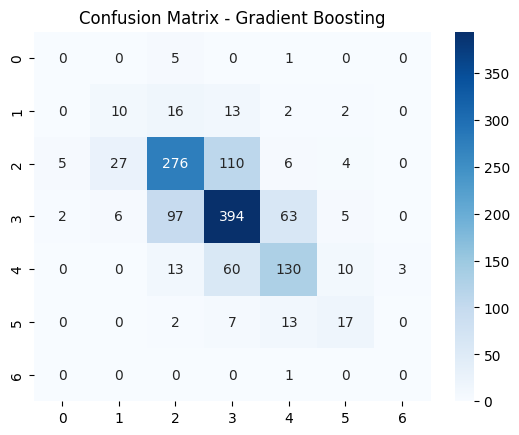

The best model is: Gradient Boosting with an accuracy of 0.6362
Best model saved as 'best_model.pkl'


In [93]:
# Create a DataFrame to display results
results_df = pd.DataFrame(results).T
results_df = results_df.drop(columns=['Confusion Matrix'])  # Dropping confusion matrix for clarity

# Display the summary table
print("Summary of Model Performance:")
print(results_df)

# Save the results table as a CSV file
results_df.to_csv("model_performance_summary.csv", index=True)
print("Model performance summary saved as 'model_performance_summary.csv'")

# Visualization of the confusion matrix of the best model
sns.heatmap(results[max(results, key=lambda x: results[x]['Accuracy'])]['Confusion Matrix'], annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {max(results, key=lambda x: results[x]['Accuracy'])}")
plt.show()

print(f"The best model is: {max(results, key=lambda x: results[x]['Accuracy'])} with an accuracy of {best_accuracy:.4f}")

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print("Best model saved as 'best_model.pkl'")

# 5. Conclusion

Based on the performance summary and confusion matrix  for the Gradient Boosting model, we can draw several conclusions about the effectiveness of the various models tested on the wine quality classification task:

## Summary of Findings:
### Model Performance:

*   Gradient Boosting demonstrated the highest overall accuracy of 0.636, along
with robust precision and F1-scores. This suggests that Gradient Boosting is particularly effective for this dataset, likely due to its capability of handling the non-linear relationships and interactions between features.
*   Random Forest also performed well, showing strong accuracy and precision, which indicates its effectiveness in ensemble learning scenarios for this type of data.
*   Support Vector Machine and Multilayer Perceptron exhibited lower performance metrics compared to ensemble methods, which might be due to their sensitivity to the scale of the data or the need for more fine-tuned hyperparameter settings.

### Confusion Matrix Insights:

*   The confusion matrix for the Gradient Boosting model reveals that while the model is quite effective at predicting certain classes (e.g., class 2), it struggles with others (e.g., class 0 and class 6). This could indicate areas where further model tuning or additional data collection might improve performance.
*   The model shows a strong ability to predict the majority classes but less effectiveness with minority classes, highlighting a common challenge in imbalanced datasets.

### Practical Implications:

*   The results suggest that Gradient Boosting is the most suitable model for deployment if the goal is to maximize overall accuracy and balance between precision and recall across classes.
*   The variation in model performance across different metrics underscores the importance of choosing the right evaluation criteria based on the specific needs of the wine quality assessment (e.g., whether false positives or false negatives have a higher cost).

## Recommendations for Further Research:
*   Data Augmentation: Additional data collection, especially for underrepresented classes, could help improve model training and the robustness of predictions.
*   Advanced Feature Engineering: Further analysis to identify and engineer new features could provide models with more predictive power.
*   Model Ensembling: Combining predictions from multiple models could help overcome individual model limitations and improve prediction accuracy.

# Conclusion:
Unfortunately, excellent results were not achieved with the data on the physicochemical properties of wine and the characteristics of the dataset. [Other studies](https://rstudio-pubs-static.s3.amazonaws.com/175762_83cf2d7b322c4c63bf9ba2487b79e77e.html) carried out with this dataset that separate the quality classification into different models for white and red wines, obtain similar results to those obtained in this notebook, so it would be interesting to add real instances of low and high quality wines; as well as to verify the need for new features that can influence the classification.